# Automathon 2024

In [1]:
!pip install pyav

## Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.io as io
import os
import json
from tqdm import tqdm
import csv
import timm
import wandb
import time

from PIL import Image
import torchvision.transforms as transforms

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utilities

In [3]:
import matplotlib.pyplot as plt

def display_image(img):
    img = img.permute(1,2,0)
    plt.imshow(img)
    
def extract_frames(video_path, nb_frames=10, delta=1, timeit=False):
    # use time to measure the time it takes to resize a video
    t1 = time.time()
    reader = io.VideoReader(video_path)
    # take 10 frames uniformly sampled from the video
    frames = []
    for i in range(nb_frames):
        reader.seek(delta)
        frame = next(reader)
        frames.append(frame['data'])
    t2 = time.time()     
    video = torch.stack(frames)
    if timeit:
        print(f"read: {t2-t1}")
    return video

def smart_resize(data, size): # kudos louis
    # Prends un tensor de shape [...,C,H,W] et le resize en [...C,size,size]
    # x, y, height et width servent a faire un crop avant de resize

    full_height = data.shape[-2]
    full_width = data.shape[-1]

    if full_height > full_width:
        alt_height = size
        alt_width = int(full_width / (full_height / size))
    elif full_height < full_width:
        alt_height = int(full_height / (full_width / size))
        alt_width = size
    else:
        alt_height = size
        alt_width = size
    tr = transforms.Compose([
        transforms.Resize((alt_height, alt_width)),
        transforms.CenterCrop(size)
    ])
    return tr(data)

def resize_data(data, new_height, new_width, x=0, y=0, height=None, width=None):
    # Prends un tensor de shape [...,C,H,W] et le resize en [...,C,new_height,new_width]
    # x, y, height et width servent a faire un crop avant de resize
    
    full_height = data.shape[-2]
    full_width = data.shape[-1]
    height = full_height - y if height is None else height
    width = full_width -x if width is None else width

    ratio = new_height/new_width
    if height/width > ratio:
        expand_height = height
        expand_width = int(height / ratio)
    elif height/width < ratio:
        expand_height = int(width * ratio)
        expand_width = width
    else:
        expand_height = height
        expand_width = width
    tr = transforms.Compose([
        transforms.CenterCrop((expand_height, expand_width)),
        transforms.Resize((new_height, new_width))
    ])
    x = data[...,y:min(y+height, full_height), x:min(x+width, full_width)].clone()
    return tr(x)

## Setup du Dataset

In [9]:

dataset_dir = "/Users/georgiaabouchebel/automathon-2024-gr25/experimental_dataset"
root_dir = os.path.expanduser("/Users/georgiaabouchebel/automathon-2024-gr25/experimental_dataset")

nb_frames = 10

class VideoDataset(Dataset):
    """
    This Dataset takes a video and returns a tensor of shape [10, 3, 256, 256]
    That is 10 colored frames of 256x256 pixels.
    """
    def __init__(self, root_dir, dataset_choice="train", nb_frames=10):
        super().__init__()
        self.dataset_choice = dataset_choice
        if  self.dataset_choice == "test":
            self.root_dir = os.path.join(root_dir, "test")
        elif  self.dataset_choice == "experimental":
            self.root_dir = os.path.join(root_dir, "train")
        else:
            raise ValueError("choice must be 'test' or 'experimental'")

        with open(os.path.join(root_dir, "dataset.csv"), 'r') as file:
            reader = csv.reader(file)
            # read dataset.csv with id,label columns to create
            # a dict which associated label: id
            self.ids = {row[1] : row[0] for row in reader}

        if self.dataset_choice == "test":
            self.data = None
        else:
            with open(os.path.join(self.root_dir, "metadata.json"), 'r') as file:
                self.data= json.load(file)
                self.data = {k : (torch.tensor(float(1)) if v == 'fake' else torch.tensor(float(0))) for k, v in self.data.items()}

        self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.mp4')]
        #self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.pt')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        #video, audio, info = io.read_video(video_path, pts_unit='sec')
        #video = torch.load(video_path)
        
        video = extract_frames(video_path)
        
        #video = video.permute(0,3,1,2)
        #length = video.shape[0]
        #video = video[[i*(length//(nb_frames)) for i in range(nb_frames)]]
        
        # resize the data into a reglar shape of 256x256 and normalize it
        video = smart_resize(video, 256) / 255
        #video = video / 255

        ID = self.ids[self.video_files[idx]]
        if self.dataset_choice == "test":
            return video, ID
        else:
            label = self.data[self.video_files[idx]]
            return video, label, ID



#train_dataset = VideoDataset(dataset_dir, dataset_choice="train", nb_frames=nb_frames)
test_dataset = VideoDataset(dataset_dir, dataset_choice="test", nb_frames=nb_frames)
experimental_dataset = VideoDataset(dataset_dir, dataset_choice="experimental", nb_frames=nb_frames)


Voici comment afficher un frame du dataset:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/video_reader.py:233: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


tensor(1.)
torch.Size([10, 3, 256, 256])


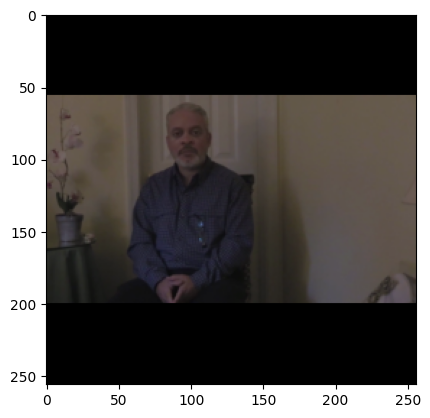

In [10]:
video, label, ID = experimental_dataset[10]
img = video[0]

display_image(img)
print(label)
print(video.shape)

Et comment faire un resize

torch.Size([3, 256, 256])


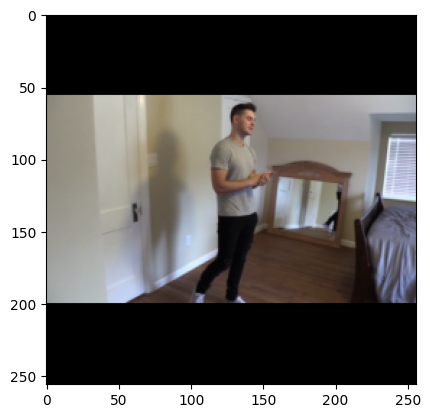

In [11]:
video, label, ID = experimental_dataset[0]
img=video[0]

img=smart_resize(img, 256)
print(img.shape)
display_image(img)

## Modèle

In [12]:
class DeepfakeDetector(nn.Module):
    def __init__(self, nb_frames=10):
        super().__init__()
        self.dense = nn.Linear(nb_frames*3*256*256,1)
        self.flat = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.flat(x)
        y = self.dense(y)
        y = self.sigmoid(y)
        return y


model = DeepfakeDetector(nb_frames=nb_frames)
print(video.shape)
video, label, ID = experimental_dataset[0]
video = video.unsqueeze(0) # add a batch dimension
summary(model, input_size=video.shape)

torch.Size([10, 3, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
DeepfakeDetector                         [1, 1]                    --
├─Flatten: 1-1                           [1, 1966080]              --
├─Linear: 1-2                            [1, 1]                    1,966,081
├─Sigmoid: 1-3                           [1, 1]                    --
Total params: 1,966,081
Trainable params: 1,966,081
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.97
Input size (MB): 7.86
Forward/backward pass size (MB): 0.00
Params size (MB): 7.86
Estimated Total Size (MB): 15.73

## Logging

In [13]:
wandb.login(key="a446d513570a79c857317c3000584c5f6d6224f0")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/georgiaabouchebel/.netrc


True

In [14]:
run = wandb.init(
    project="automathon",
)

wandb: Currently logged in as: mfkyjgwswhypqbrvhh (automathon2024). Use `wandb login --relogin` to force relogin


## Entrainement

In [15]:
torch.cuda.device_count()

0

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_fn = nn.MSELoss()
#model = DeepfakeDetector().to(device)
model = DeepfakeDetector().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#epochs = 5
epochs = 1
loader = DataLoader(experimental_dataset, batch_size=2, shuffle=True)

for epoch in range(epochs):
    for sample in tqdm(loader, desc="Epoch {}".format(epoch), ncols=0):
        optimizer.zero_grad()
        X, label, ID = sample
        #X = X.to(device)
        #label = label.to(device)
        X = X.cuda()
        label = label.cuda()
        label_pred = model(X)
        label=torch.unsqueeze(label,dim=1)
        loss = loss_fn(label, label_pred)
        loss.backward()
        optimizer.step()
        run.log({"loss": loss.item(), "epoch": epoch})

cpu


AssertionError: Torch not compiled with CUDA enabled

## Test

In [37]:
loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
model = model.to(device)
ids = []
labels = []
print("Testing...")
for sample in tqdm(loader):
    X, ID = sample
    #ID = ID[0]
    X = X.to(device)
    label_pred = model(X)
    ids.extend(list(ID))
    pred = (label_pred > 0.5).long()
    pred = pred.cpu().detach().numpy().tolist()
    labels.extend(pred)


Testing...


100%|██████████| 557/557 [06:32<00:00,  1.42it/s]


### Saving

In [38]:
print("Saving...")
tests = ["id,label\n"] + [f"{ID},{label_pred[0]}\n" for ID, label_pred in zip(ids, labels)]
with open("submission.csv", "w") as file:
    file.writelines(tests)


Saving...
